# 🧠 Brain Tumor 3D [Inference]

### Hi kagglers, This is `Inference` notebook using `Keras`.

> 
* [Brain Tumor 3D [Training]](https://www.kaggle.com/ammarnassanalhajali/brain-tumor-3d-training) 
* [Brain Tumor 3D [EDA]](https://www.kaggle.com/ammarnassanalhajali/brain-tumor-3d-eda)


### Please if this kernel is useful, <font color='red'>please upvote !!</font>

## ☀️ Importing Libraries

In [ ]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re
import math
import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

from random import shuffle
from sklearn import model_selection as sk_model_selection

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa

# Loading Data

In [ ]:
data_directory = '../input/rsna-miccai-brain-tumor-radiogenomic-classification'
pytorch3dpath = "../input/efficientnetpyttorch3d/EfficientNet-PyTorch-3D"
 
mri_types = ['FLAIR','T1w','T1wCE','T2w']
IMAGE_SIZE = 256
NUM_IMAGES = 48

In [ ]:
sample_submission = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/sample_submission.csv')
test=sample_submission
test['BraTS21ID5'] = [format(x, '05d') for x in test.BraTS21ID]
test.head(3)

# Functions to load images


In [ ]:
def load_dicom_image(path, img_size=IMAGE_SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data


def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=IMAGE_SIZE, mri_type="FLAIR", split="test", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

a = load_dicom_images_3d("00001")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))
image = a[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))  
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()
# Visualize montage of slices.
# 5 rows and 10 columns for 100 slices of the CT scan.
plot_slices(3, 10, 256, 256, image[:, :, :30])

#  Custom Data Generator

In [ ]:
from keras.utils import Sequence
class Dataset(Sequence):
    def __init__(self,df,is_train=True,batch_size=1,shuffle=True):
        self.idx = df["BraTS21ID"].values
        self.paths = df["BraTS21ID5"].values
        self.y =  df["MGMT_value"].values
        self.is_train = is_train
        self.batch_size = batch_size
        self.shuffle = shuffle
    def __len__(self):
        return math.ceil(len(self.idx)/self.batch_size)
   
    def __getitem__(self,ids):
        id_path= self.paths[ids]
        batch_paths = self.paths[ids * self.batch_size:(ids + 1) * self.batch_size]
        
        if self.y is not None:
            batch_y = self.y[ids * self.batch_size: (ids + 1) * self.batch_size]
            
        list_x =  load_dicom_images_3d(id_path)#str(scan_id).zfill(5)
        #list_x =  [load_dicom_images_3d(x) for x in batch_paths]
        batch_X = np.stack(list_x)
        if self.is_train:
            return batch_X,batch_y
        else:
            return batch_X
    
    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.idx, self.y))
            shuffle(ids_y)
            self.idx, self.y = list(zip(*ids_y))

In [ ]:
#train_dataset = Dataset(df_train)
#valid_dataset = Dataset(df_valid)
test_dataset = Dataset(test,is_train=False)

In [ ]:
for i in range(1):
    image = test_dataset[i]
    print("Dimension of the CT scan is:", image.shape)
    plt.imshow(image[0,:,:, 30], cmap="gray")
    plt.show()

In [ ]:
def get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
     
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.01)(x)
    
    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.02)(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.03)(x)

    x = layers.Conv3D(filters=512, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.04)(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.08)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")

    return model

# Build model.
model = get_model(width=IMAGE_SIZE, height=IMAGE_SIZE, depth=64)
model.summary()

# Loading Model

In [ ]:
model.load_weights('../input/brain-tumor-3d-classification-weights2/Brain_3d_cls_FLAIR.h5')

model = keras.Model()
model = tf.keras.models.load_model('../input/brain-tumor-3d-weights-l/Brain_3d_cls_FLAIR.h5')

# Make predictions

In [ ]:
preds = model.predict(test_dataset)
preds = preds.reshape(-1)

In [ ]:
preds

In [ ]:
submission = pd.DataFrame({'BraTS21ID':sample_submission['BraTS21ID'],'MGMT_value':preds})

In [ ]:
submission

In [ ]:
submission.to_csv('submission.csv',index=False)

In [ ]:
plt.figure(figsize=(5, 5))
plt.hist(submission["MGMT_value"]);

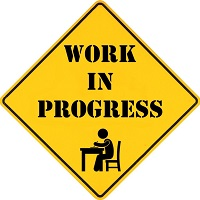

# References

1. https://keras.io/examples/vision/3D_image_classification/
1. https://www.kaggle.com/rluethy/efficientnet3d-with-one-mri-type
